## Import och funktioner

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


In [4]:
# Ladda data
mnist = fetch_openml('mnist_784', version=1, cache = True, as_frame = False)
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

# Splitta data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Funktion för att visualisera confusion matrix senare

def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot()

## EDA

In [29]:
# Vi har 70 000 rader och 784 features. Detta stämmer bra eftersom 28X28 = 784
print(X.shape)
print(y.shape)

# I DESCR kan vi få information om hur datasetet är skapat och annan viktig information som kommer vara väldigt viktig för våran preprocessing av bilder senare.
print(mnist.DESCR)

(70000, 784)
(70000,)
**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were cente

True label for plottet image is 5


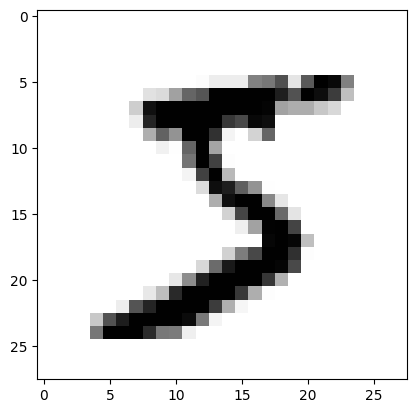

In [30]:
# Visualiserar en klass för att få en känsla av hur de kan se ut
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
print("True label for plottet image is", y[0])

Här nedan ser vi att det finns 256 olika värden i X vilket är bra eftersom det motsvarar mängden nyanser i gråskalan

In [ ]:
np.unique(X_train)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [32]:
# Gör om till en DataFrame för att göra EDA lättare
y_train_df = pd.DataFrame(y_train)
X_train_df = pd.DataFrame(X_train)

Här ser vi att vi verkar ha bra fördelad träningsdata. Det finns ingen kategorier med extremt få mängder.

In [33]:
y_train_df.value_counts()


0
1    6277
7    5790
3    5708
2    5610
0    5560
9    5538
4    5529
6    5480
8    5468
5    5040
Name: count, dtype: int64

## Modellering

Här väljer jag ut mina modeller och lägger de i listor

In [6]:
logreg_clf = LogisticRegression()
extra_trees_clf = ExtraTreesClassifier()
svc_clf = SVC()

models_results = {}

### LogisticRegression

In [ ]:
scaler = StandardScaler()

pipeline = Pipeline([
    ("scaler", scaler),
    ("model", logreg_clf)
])

cv = 3

param_grid = {
    "model__C": [0.01, 0.1, 1],
    "model__max_iter": [1000]
}

logreg_grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    verbose=1
)
logreg_grid.fit(X_train, y_train)
logreg_accuracy = logreg_grid.best_score_
logreg_params = logreg_grid.best_params_
models_results["LogisticRegression"] = {"Best accuracy": round(logreg_accuracy,4)}

In [37]:
print(f"Accuracy: {logreg_accuracy}")
print(f"Best hyperparams: {logreg_params}")

Accuracy: 0.9183749999999999
Best hyperparams: {'model__C': 0.1, 'model__max_iter': 1000}


### ExtraTrees

Eftersom att det gick så fruktansvärt långsamt så var jag tvungen att gå ner till cv 3. Jag kommer därför göra det i alla modeller även de tidigare.

Testade också med max_features och fick sqrt som är standardvalet så valde att bara kommentera bort det för att spara tid men ändå visa på att de varit med tidigare

In [ ]:
scaler = StandardScaler()

pipeline = Pipeline([
    ("scaler", scaler),
    ("model", extra_trees_clf)
])

cv = 3

param_grid = {
    "model__n_estimators": [250, 500],
   # "model__max_features": ["sqrt", "log2"]
}

extra_trees_grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    verbose=1
)
extra_trees_grid.fit(X_train, y_train)

extra_trees_accuracy = extra_trees_grid.best_score_
extra_trees_params = extra_trees_grid.best_params_
models_results["ExtraTrees"] = {"Best accuracy": round(extra_trees_accuracy,4)}

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [55]:
print(f"Accuracy: {extra_trees_accuracy}")
print(f"Best hyperparams: {extra_trees_params}")

Accuracy: 0.9705357075703748
Best hyperparams: {'model__n_estimators': 250}


### SVC

In [ ]:
scaler = StandardScaler()

pipeline = Pipeline([
    ("scaler", scaler),
    ("model", svc_clf)
])

cv = 3

param_grid = {
    "model__C": [10,100],
    "model__kernel" :["rbf"],
    "model__gamma": ["scale",0.01]
}

svc_grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    verbose=1
)
svc_grid.fit(X_train, y_train)
svc_accuracy = svc_clf.best_score_
svc_params = svc_clf.best_params_
models_results["SVC"] = {"Best accuracy": round(svc_accuracy,4)}

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [ ]:
print(f"Accuracy: {svc_accuracy}")
print(f"Best hyperparams: {svc_params}")

In [ ]:
print("Accuracy for each model")
print(models_results)


Accuracy for each model
{'LogisticRegression': {'Best accuracy': np.float64(0.9184), 'Best params': {'model__C': 0.1, 'model__max_iter': 1000}}}
